<a href="https://colab.research.google.com/github/Oluhle080/MUT-Shuttle-Graph/blob/main/NHL_in_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset Relevance Justification**
For this project, focused on Predicting Healthcare Service Demand under South Africa’s National Health Insurance (NHI) system, I selected the dataset titled “healthDatafile.xlsb”, which contains multiple interrelated tables covering district-level healthcare statistics, facility distributions, bed densities, and healthcare ranking metrics across South African regions.

This dataset is highly relevant for several reasons:

Multi-relational Structure:
The dataset includes multiple related tables — District healthcare usage (District_all), healthcare facilities (Facilities), bed density (BUR_BedDensity), and district ranks (District_ranks). This multi-table format enables comprehensive analysis across different aspects of healthcare infrastructure and service delivery.

Regional Healthcare Usage Data:
The district-level healthcare usage data provides historical service utilization figures that are crucial for building predictive models estimating future demand for healthcare services in various districts.

Facility and Resource Information:
Data on healthcare facilities and bed availability per district allows for modeling supply-side factors, helping to explain variations in healthcare demand based on available resources.

Alignment with NHI Objectives:
Since the NHI aims to improve equitable access to healthcare across all regions, understanding district-level demand and resource capacity is essential. This dataset supports analyzing disparities and forecasting service needs to better allocate funding and resources.

Data Quality and Accessibility:
The dataset is publicly available, well-structured, and includes data spanning multiple years, providing sufficient depth for trend analysis and machine learning modeling.

While the dataset does not contain patient-level demographic or medical history data, it offers a practical and relevant foundation for aggregate healthcare demand prediction, fitting well within the project’s scope and timeline.

Madide SN 22314172

mount google drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

install required packages

In [ ]:
!pip install pyxlsb openpyxl scikit-learn matplotlib seaborn

load excel binary file

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
sns.set(style='whitegrid')

load health datafile from google drive

In [ ]:
file_path="/content/drive/MyDrive/dataset/healthDatafile.xlsb"

load excel file with pyxlsb engine



In [ ]:
xlsb = pd.ExcelFile(file_path, engine='pyxlsb')

print all sheet names to verify

In [ ]:
print("Available sheets:", xlsb.sheet_names)

Available sheets: ['Notes', 'Defn', 'ZA', 'Ind', 'Prov', 'District_single', 'District_all', 'BUR_BedDensity', 'District_ranks', 'AllDistricts_ranks', 'LM', 'SectionA', 'SectionB', 'Facilities', 'Fac_listing', 'Time_periods']


load sheets,skipping top rows

In [ ]:
district_df = pd.read_excel(xlsb, sheet_name='District_all', engine='pyxlsb', skiprows=3)
facilities_df = pd.read_excel(xlsb, sheet_name='Facilities', engine='pyxlsb', skiprows=2)
beds_df = pd.read_excel(xlsb, sheet_name='BUR_BedDensity', engine='pyxlsb', skiprows=3)
ranks_df = pd.read_excel(xlsb, sheet_name='District_ranks', engine='pyxlsb', skiprows=4)


data cleaning functions

In [ ]:
def clean_columns(df):
    """Strip whitespace from column names."""
    df.columns = df.columns.str.strip()
    return df

def rename_first_col(df, new_name='District'):
    """Rename first column to 'District' for consistent merging key."""
    df.rename(columns={df.columns[0]: new_name}, inplace=True)
    return df

appying cleaning

In [ ]:
district_df = clean_columns(district_df)
facilities_df = clean_columns(facilities_df)
beds_df = clean_columns(beds_df)
ranks_df = clean_columns(ranks_df)

district_df = rename_first_col(district_df)
facilities_df = rename_first_col(facilities_df)
beds_df = rename_first_col(beds_df)
ranks_df = rename_first_col(ranks_df)

extracting year 2021 data

In [ ]:
def extract_2021(df):
    """Extract columns related to 2021; fallback to numeric columns."""
    year_cols = [col for col in df.columns if '2021' in str(col)]
    if not year_cols:
        year_cols = df.select_dtypes(include='number').columns.tolist()
    return df[['District'] + year_cols]

district_2021 = extract_2021(district_df)
facilities_2021 = extract_2021(facilities_df)
beds_2021 = extract_2021(beds_df)
ranks_2021 = extract_2021(ranks_df)


standardizing district values

In [ ]:
for df in [district_2021, facilities_2021, beds_2021, ranks_2021]:
    df['District'] = df['District'].astype(str).str.strip().str.upper()

/tmp/ipython-input-437733860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['District'] = df['District'].astype(str).str.strip().str.upper()
/tmp/ipython-input-437733860.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['District'] = df['District'].astype(str).str.strip().str.upper()


Removing invalid errors

In [ ]:
# Example: drop rows where District is 'IND_NAME', 'RECENTYEAR' or similar metadata
def filter_valid_districts(df):
    invalid_keywords = ['IND_NAME', 'RECENTYEAR', 'GEO_LEVEL_NO', 'AVERAGE', 'ROW LABELS', 'DATA_SERIES', 'GEO_DISTRICT']
    mask = ~df['District'].isin(invalid_keywords)
    return df[mask]

district_2021 = filter_valid_districts(district_2021)
facilities_2021 = filter_valid_districts(facilities_2021)
beds_2021 = filter_valid_districts(beds_2021)
ranks_2021 = filter_valid_districts(ranks_2021)

merging dataframe in district

In [ ]:
df_merged = district_2021.merge(facilities_2021, on='District', how='left', suffixes=('', '_facilities'))
df_merged = df_merged.merge(beds_2021, on='District', how='left', suffixes=('', '_beds'))
df_merged = df_merged.merge(ranks_2021, on='District', how='left', suffixes=('', '_ranks'))

handle missing values

In [ ]:
df_merged.fillna(0, inplace=True)


display sample and stats

In [ ]:
print("\nMerged dataset sample:")
print(df_merged.head())

print("\nSummary statistics:")
print(df_merged.describe())


Merged dataset sample:
                District  District Hospital  Regional Hospital  \
0                    NAN                0.0                0.0   
1                    NAN                0.0                0.0   
2                    NAN                0.0                0.0   
3  AVERAGE OF DATA_VALUE                0.0                0.0   
4                    NAN                0.0                0.0   

   Provincial Tertiary Hospital  National Central Hospital  Unnamed: 5  \
0                           0.0                        0.0         0.0   
1                           0.0                        0.0         0.0   
2                           0.0                        0.0         0.0   
3                           0.0                        0.0         0.0   
4                           0.0                        0.0         0.0   

   Specialised Psychiatric Hospital  Specialised TB Hospital  Unnamed: 8  \
0                               0.0                      0

correlation heatmap

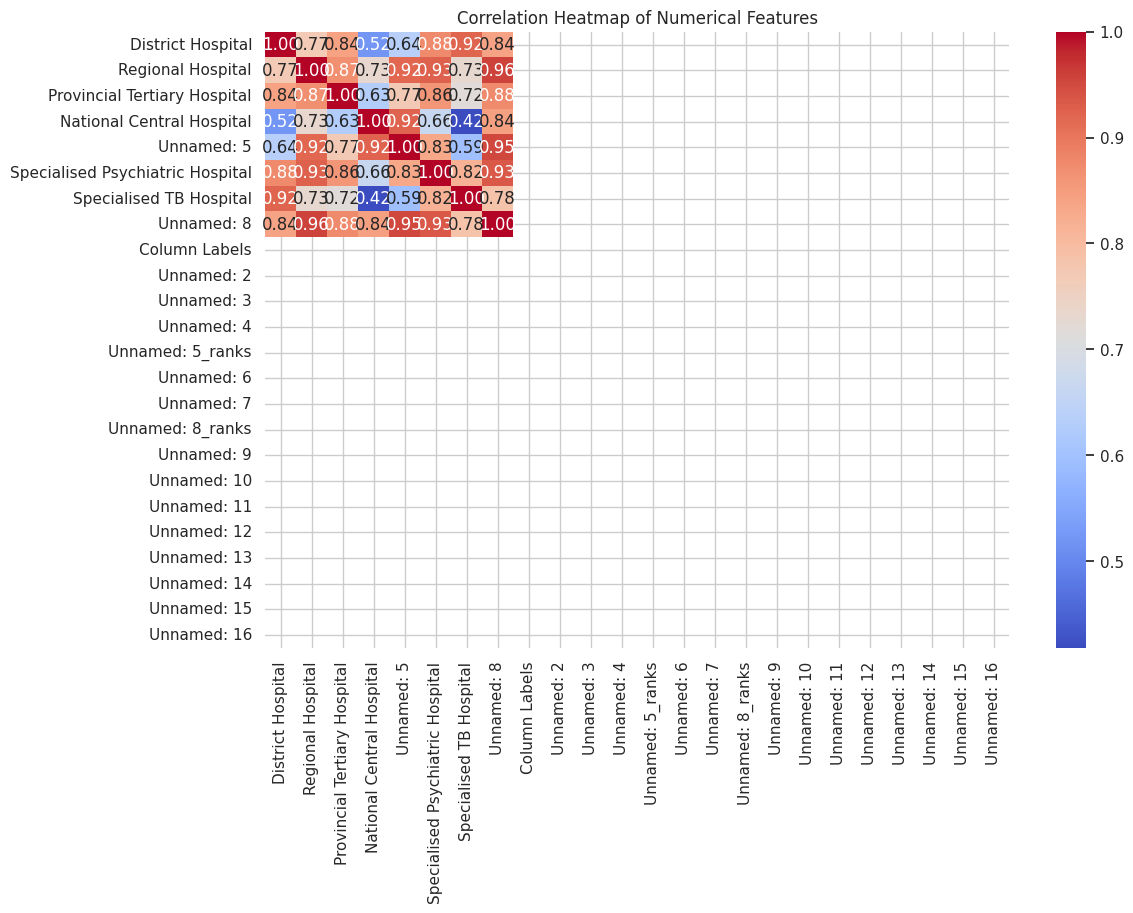

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_merged.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

preparing data for learning machine

In [ ]:
# Target: First numeric column from district_2021 after 'District'
# target_col = district_2021.columns[0]
# Features: all numeric columns excluding District and target

# Corrected: Select 'District Hospital' as the target and all other numeric columns as features
target_col = 'District Hospital'
feature_cols = [col for col in df_merged.select_dtypes(include=np.number).columns if col not in ['District', target_col]]


X = df_merged[feature_cols]
y = df_merged[target_col]

print(f"\nTarget variable: {target_col}")
print(f"Number of features: {len(feature_cols)}")


Target variable: District Hospital
Number of features: 23


In [ ]:
# Convert all features to numeric, coercing errors to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN in features or target
data_clean = pd.concat([X, y], axis=1).dropna()

X_clean = data_clean[feature_cols]
y_clean = data_clean[target_col]

print(f"Cleaned dataset size: {X_clean.shape[0]} samples")


Cleaned dataset size: 146 samples


traing test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model training

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

model prediction and evaluation

In [ ]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")


Model Performance on Test Set:
Mean Squared Error (MSE): 0.610
R^2 Score: 0.977


feature importance

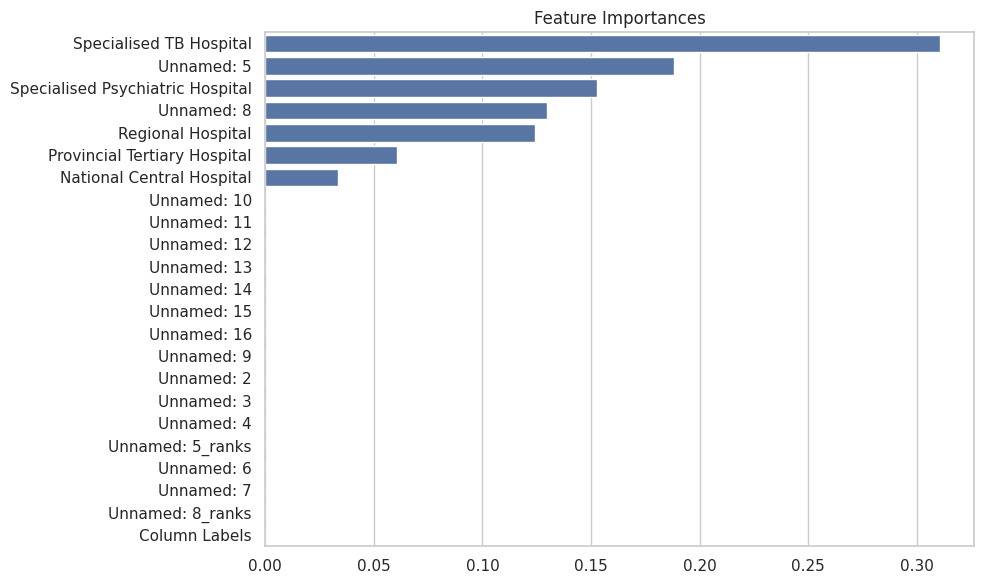

In [ ]:

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=np.array(feature_cols)[indices])
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

model evaluation

Mean Squared Error: 0.61
R-squared: 0.98


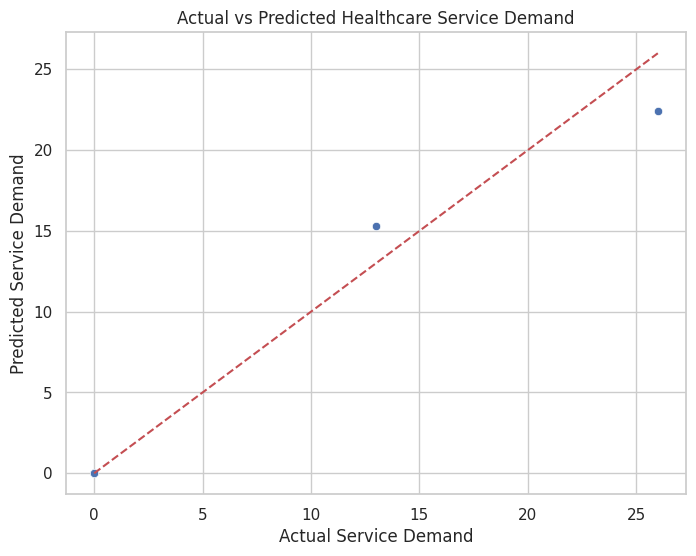

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Service Demand')
plt.ylabel('Predicted Service Demand')
plt.title('Actual vs Predicted Healthcare Service Demand')
plt.show()


visualization

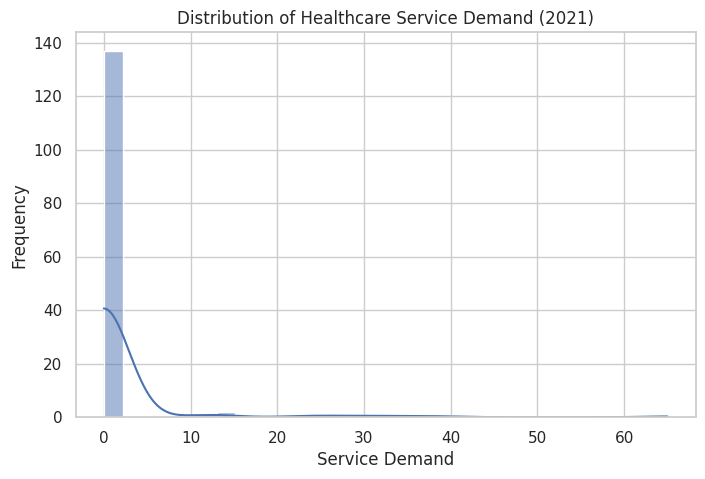

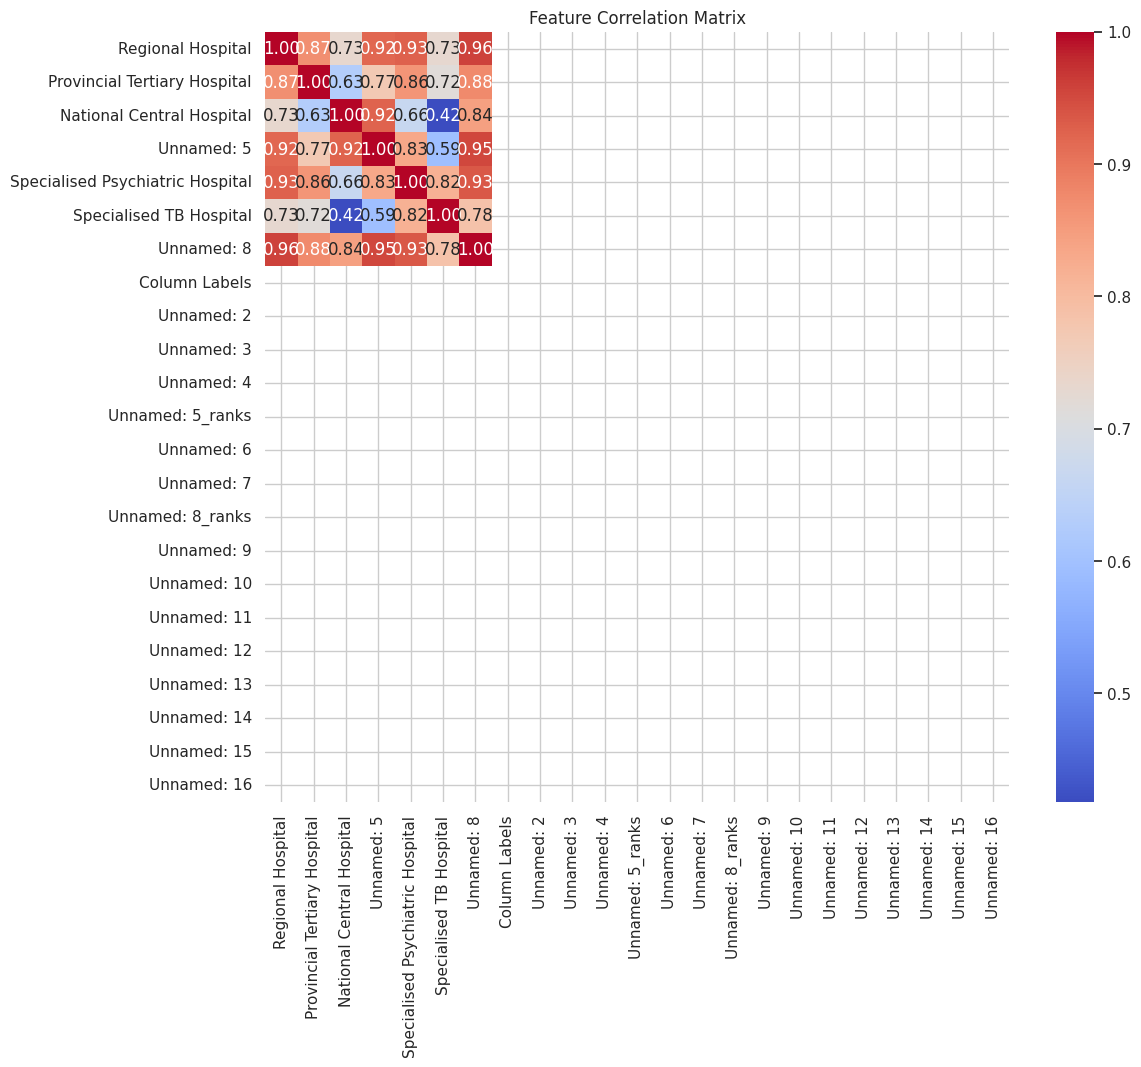

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(y_clean, bins=30, kde=True)
plt.title('Distribution of Healthcare Service Demand (2021)')
plt.xlabel('Service Demand')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(X_clean.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()
